In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns

## Part 1: Training forests and logistic regression

In [2]:
# import csv
df = pd.read_csv('../bigass.csv', index_col=0)

In [ ]:
# remove non-numerical data and separate target
X = df.drop(['artist','picture','Van Gogh'],axis=1)
y = df['Van Gogh']

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                 test_size = 0.25,
                                                 shuffle=True,
                                                 stratify=y)

In [ ]:
# creating class-balanced data sets from the training and test set by downsampling non-VG

VG_idx = y_train[y_train == 1].index
not_VG_idx = y_train[y_train == 0].sample(sum(y_train)).index
idx = np.concatenate([VG_idx,not_VG_idx])

X_balanced = X_train.loc[idx]
y_balanced = y_train[idx]

VG_idx_test = y_test[y_test == 1].index
not_VG_idx_test = y_test[y_test == 0].sample(sum(y_test)).index
idx_test = np.concatenate([VG_idx_test,not_VG_idx_test])

X_balanced_test = X_test.loc[idx_test]
y_balanced_test = y_test[idx_test]

In [ ]:
# train trees and save all the data into random_forest_scores
# do not run this cell unless you're willing to wait about a day:
# cross_validate means each num_tree+depth combo is trained 5 times!
# that's 4x6x2x5=240 distinct trees, and some of them are pretty big/deep!
num_trees = [100, 300, 1000, 3000]
depths = [5, 15, 50, 150, 500, 1000]
random_forest_scores = []

for num_tree in num_trees:
    num_tree_scores = []
    for depth in depths:
        rfc = RandomForestClassifier(n_estimators=num_tree, max_depth=depth)
        rfc_bal = clone(rfc)
        unbal_forest_score = cross_validate(rfc, X_train, y_train,
                                            scoring=['accuracy', 'balanced_accuracy', 'precision', 'recall'],
                                            cv=5,
                                            return_train_score=True,
                                            return_estimator=True)
        bal_forest_score = cross_validate(rfc_bal, X_balanced, y_balanced,
                                          scoring=['accuracy', 'balanced_accuracy', 'precision', 'recall'],
                                          cv=5,
                                          return_train_score=True,
                                          return_estimator=True)
        num_tree_scores.append([unbal_forest_score, bal_forest_score])
    random_forest_scores.append(num_tree_scores)

In [ ]:
# choose best forest from each setting based on validation accuracy
best_models = []
for i in range(len(random_forest_scores)):
    for j in range(len(random_forest_scores[i])):
        cur_models = random_forest_scores[i][j][1]
        best_index = cur_models['test_balanced_accuracy'].argmax()
        best_models.append((num_trees[i], depths[j], cur_models['estimator'][best_index],
                            np.round(cur_models['test_balanced_accuracy'][best_index],3)))

In [ ]:
# print metrics of chosen model on test set
y_pred = best_models[8][2].predict(X_test)
print('accuracy: ' + str(np.round(accuracy_score(y_test, y_pred),3)))
print('precision: ' + str(np.round(precision_score(y_test, y_pred),3)))
print('recall: ' + str(np.round(recall_score(y_test, y_pred),3)))

In [ ]:
# train logistic regressions

lrc_balanced = LogisticRegression(max_iter=10000)
lrc_train = LogisticRegression(max_iter=10000)

lrc_balanced.fit(X_balanced, y_balanced)
lrc_train.fit(X_train, y_train)

In [ ]:
printout(lrc_balanced)
printout(lrc_train)


In [ ]:
# old version - useful only if you know EXACTLY what each printout is! (the datasets are not disjoint)
def printout(model):
    y_balanced_pred = model.predict(X_balanced)
    y_balanced_test_pred = model.predict(X_balanced_test)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('Balanced accuracy: ' + str(np.round(accuracy_score(y_balanced, y_balanced_pred),3)))
    print('Balanced precision: ' + str(np.round(precision_score(y_balanced, y_balanced_pred),3)))
    print('Balanced recall: ' + str(np.round(recall_score(y_balanced, y_balanced_pred),3)))
    print()
    print('Balanced test accuracy: ' + str(np.round(accuracy_score(y_balanced_test, y_balanced_test_pred),3)))
    print('Balanced test precision: ' + str(np.round(precision_score(y_balanced_test, y_balanced_test_pred),3)))
    print('Balanced test recall: ' + str(np.round(recall_score(y_balanced_test, y_balanced_test_pred),3)))
    print()
    print('Train accuracy: ' + str(np.round(accuracy_score(y_train, y_train_pred),3)))
    print('Train precision: ' + str(np.round(precision_score(y_train, y_train_pred),3)))
    print('Train recall: ' + str(np.round(recall_score(y_train, y_train_pred),3)))
    print()
    print('Test accuracy: ' + str(np.round(accuracy_score(y_test, y_test_pred),3)))
    print('Test precision: ' + str(np.round(precision_score(y_test, y_test_pred),3)))
    print('Test recall: ' + str(np.round(recall_score(y_test, y_test_pred),3)))
    print()

## Part 2: Checking whether artists can be separated linearly after PCA

In [5]:
from sklearn.decomposition import PCA

In [6]:
# prepare datasets and PCA objects

VanDeg = df.loc[df['artist'].isin({'Vincent_van_Gogh', 'Edgar_Degas'})]
VanMon = df.loc[df['artist'].isin({'Vincent_van_Gogh', 'Claude_Monet'})]
VanMan = df.loc[df['artist'].isin({'Vincent_van_Gogh', 'Edouard_Manet'})]

VanDeg_y = VanDeg['artist']
VanDeg_X = VanDeg.drop(['artist', 'picture', 'Van Gogh'], axis=1)

VanMon_y = VanMon['artist']
VanMon_X = VanMon.drop(['artist', 'picture', 'Van Gogh'], axis=1)

VanMan_y = VanMan['artist']
VanMan_X = VanMan.drop(['artist', 'picture', 'Van Gogh'], axis=1)

pcaDeg = PCA(n_components=2)
pcaMon = PCA(n_components=2)
pcaMan = PCA(n_components=2)

In [7]:
# extract PCA components
VanDeg_PCAed = pcaDeg.fit_transform(VanDeg_X/255)
VanMon_PCAed = pcaMon.fit_transform(VanMon_X/255)
VanMan_PCAed = pcaMan.fit_transform(VanMan_X/255)

<AxesSubplot:>

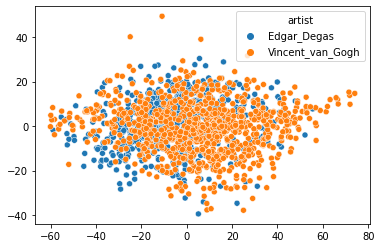

In [8]:
sns.scatterplot(x=VanDeg_PCAed[:,0],
                y=VanDeg_PCAed[:,1],
                hue=VanDeg_y)

<AxesSubplot:>

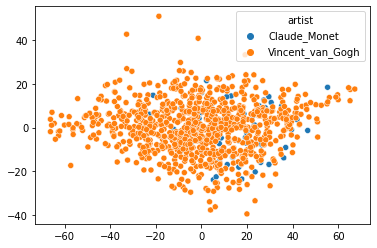

In [9]:
sns.scatterplot(x=VanMon_PCAed[:,0],
                y=VanMon_PCAed[:,1],
                hue=VanMon_y)

<AxesSubplot:>

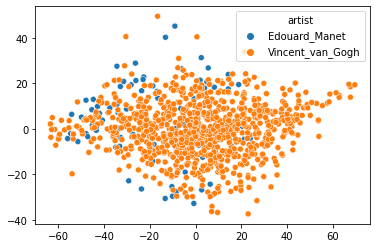

In [10]:
sns.scatterplot(x=VanMan_PCAed[:,0],
                y=VanMan_PCAed[:,1],
                hue=VanMan_y)

### The last two scatterplots show a class imbalance between Van Gogh and Monet/Manet, affecting the PCA's choice. We compare the two, and then randomly downsample Van Gogh and compare again with each one.

In [11]:
# Monet vs. Manet

MonMan = df.loc[df['artist'].isin({'Claude_Monet', 'Edouard_Manet'})]

MonMan_y = MonMan['artist']
MonMan_X = MonMan.drop(['artist', 'picture', 'Van Gogh'], axis=1)

MonMan_PCAed = PCA(n_components=2).fit_transform(MonMan_X/255)

<AxesSubplot:>

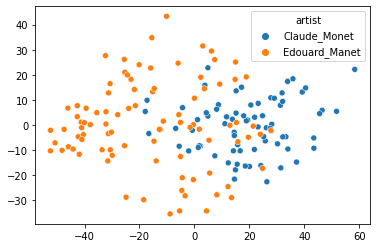

In [12]:

sns.scatterplot(x=MonMan_PCAed[:,0],
                y=MonMan_PCAed[:,1],
                hue=MonMan_y)

In [13]:
# downsampling Van Gogh in each set

VanMonBal = VanMon.drop(VanMon[VanMon.artist == 'Vincent_van_Gogh'].sample(877-75).index)
VanManBal = VanMan.drop(VanMan[VanMan.artist == 'Vincent_van_Gogh'].sample(877-90).index)

VanMonBal_y = VanMonBal['artist']
VanMonBal_X = VanMonBal.drop(['artist', 'picture', 'Van Gogh'], axis=1)

VanManBal_y = VanManBal['artist']
VanManBal_X = VanManBal.drop(['artist', 'picture', 'Van Gogh'], axis=1)

In [14]:
# extract PCA components
VanMonBal_PCAed = PCA(n_components=2).fit_transform(VanMonBal_X/255)
VanManBal_PCAed = PCA(n_components=2).fit_transform(VanManBal_X/255)

<AxesSubplot:>

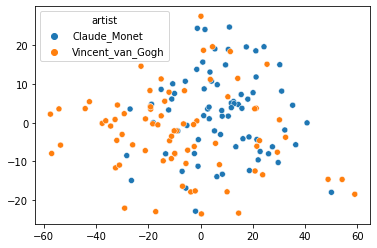

In [15]:
sns.scatterplot(x=VanMonBal_PCAed[:,0],
                y=VanMonBal_PCAed[:,1],
                hue=VanMonBal_y)

<AxesSubplot:>

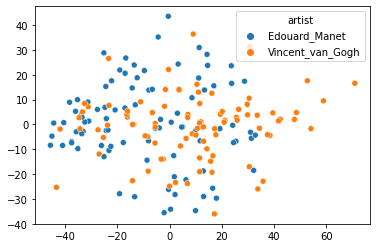

In [16]:
sns.scatterplot(x=VanManBal_PCAed[:,0],
                y=VanManBal_PCAed[:,1],
                hue=VanManBal_y)